# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [1]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# Script interface to the simulator
import ae353_spacecraft_simulate

pybullet build time: Sep  3 2024 12:57:43


Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [2]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=None,
)

argv[0]=


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [3]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [4]:
class Controller:
    def __init__(self):
        # Create a section in the resulting data set corresponding to the state estimates at each time step
        self.variables_to_log = ['xhat']
        
        # Identify the time in between each function call
        self.dt = 0.04

        # Define the equilibrium point values of the system, as well as the measurements from the sensor when the system is at equilibrium
        self.m_e =  np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        self.n_e =  np.array([0.0, 0.0, 0.0, 0.0])
        self.o_e =  np.array([0.0, -0.11820479901282371, 0.10235107129893288, 0.05911735537591688, -0.10235107129893288, 0.05911735537591688])

        # Define the matrices that describe the behaviors of the state-space model, the controller, the sensor model, and the observer
        self.A = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, -0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
        self.B = np.array([[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-2.774600038206441e-18, 0.04272118303197742, -0.021360591515988733, -0.021360591515988733], [0.0, -5.231836005589949e-18, -0.036997629785417166, 0.036997629785417166], [0.04531265733333437, -0.015104219111111459, -0.015104219111111459, -0.015104219111111459]])
        self.C = np.array([[-2.625, 0.0, -0.11820479901282367, 0.0, 0.0, 0.0], [0.0, 2.630322809337014, 0.0, 0.0, 0.0, 0.0], [-2.6289907587794437, 0.0023050379638418343, 0.05911735537591682, 0.0, 0.0, 0.0], [-0.002305037963841831, 2.626331375888245, -0.10235107129893277, 0.0, 0.0, 0.0], [-2.6289907587794437, -0.0023050379638418343, 0.05911735537591682, 0.0, 0.0, 0.0], [0.002305037963841831, 2.626331375888245, 0.10235107129893277, 0.0, 0.0, 0.0]])
        self.K = np.array([[8.164965809277264, -1.7419594010821319e-15, 1.5297145079043854e-15, 4.983245705461824e-15, -4.372961811280897e-15, 16.62190075934108], [-2.721655269759087, 1.0010861548754142e-14, 7.698003589195011, 15.671278324186519, 1.7230896685225205e-14, -5.540633586447022], [-2.7216552697590877, -6.666666666666675, -3.8490017945975072, -7.835639162093286, -13.571725138521966, -5.540633586447027], [-2.7216552697590903, 6.666666666666666, -3.8490017945975152, -7.835639162093256, 13.571725138521952, -5.540633586447034]])
        self.L = np.array([[-0.6919910495952817, -7.71755668378738e-14, -0.6930324469118608, -0.0006137668849503285, -0.6930324469660648, 0.0006137668851475917], [1.3949322732402134e-11, 0.6933866615697324, 0.00060763741899058, 0.6923344685193906, -0.0006076374327596459, 0.6923344688917267], [-1.8948837518470822, -3.0868996987845606e-10, 0.9474455798351185, -1.6406043653066957, 0.947445579909762, 1.6406043656294946], [-0.5774211769610227, -9.133695981493608e-11, 0.28871380397563917, -0.4999367272073208, 0.2887138039983804, 0.49993672731113664], [4.159695004634353e-12, 0.5779345790225483, 0.0005064629852088628, 0.577057580969686, -0.0005064629892437375, 0.5770575812929417], [-0.5767675007874705, -5.542087506065811e-14, -0.577641209198074, -0.0005082767954302424, -0.5776412092432531, 0.0005082767956105561]])

    def reset(self):
        # Set xhat to zero at the start of the simulation
        self.xhat = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    
    def run(self, t, star_measurements):
        # The variable t is the current time
        # The variable star_measurements is a 1d array of the image coordinates (y, z) of each of the measured stars, and has the shape: [y_1, z_1, y_2, z_2, y_3, z_3]
    
        # Set y equal to the difference between the actual star measurements and what the measurements are when the system is at equilibrium
        y = star_measurements - self.o_e
        
        # Define u such that it controls the system
        u = -self.K@self.xhat + self.n_e
        
        # Update the value of xhat using Euler's method
        self.xhat += (self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat - y))*self.dt

        # Set the torque of each reaction wheel to its corresponding entry in u
        torque_1 = u[0]
        torque_2 = u[1]
        torque_3 = u[2]
        torque_4 = u[3]
        
        # Return the torques to control the system
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [5]:
controller = Controller()

Reset the simulator with given initial conditions.

In [6]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, reset the simulator with initial conditions sampled at random (from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.05$).

In [7]:
simulator.reset(
    initial_conditions=None,
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Reset the controller.

In [8]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [9]:
# Set the resolution of the video as (width, height), where both values are multiples of 16
simulator.set_snapshot_size(640, 480)

# Run the trial
data = simulator.run(
    controller,           # <-- required (an instance of the Controller class)
    max_time=60.0,         # <-- optional (how long to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which the data is saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which the video is saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Check if the space-cat has docked.

In [10]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat did not dock.


Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

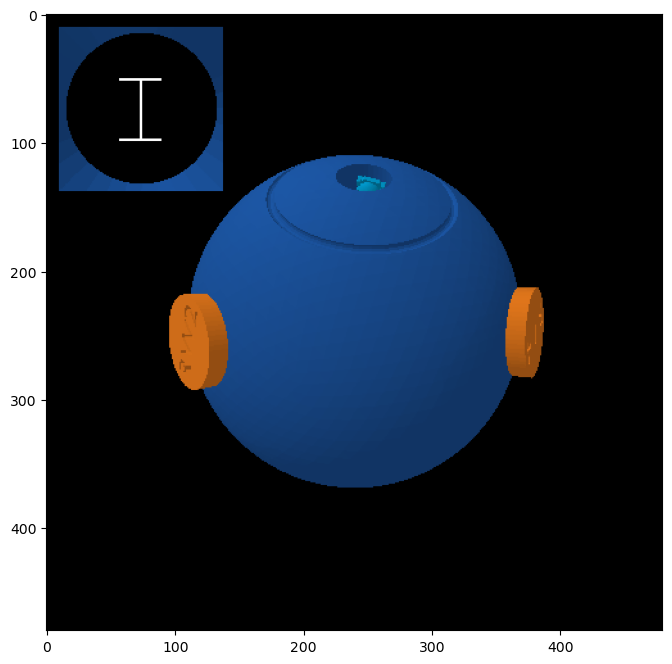

In [11]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the raw data for each variable.

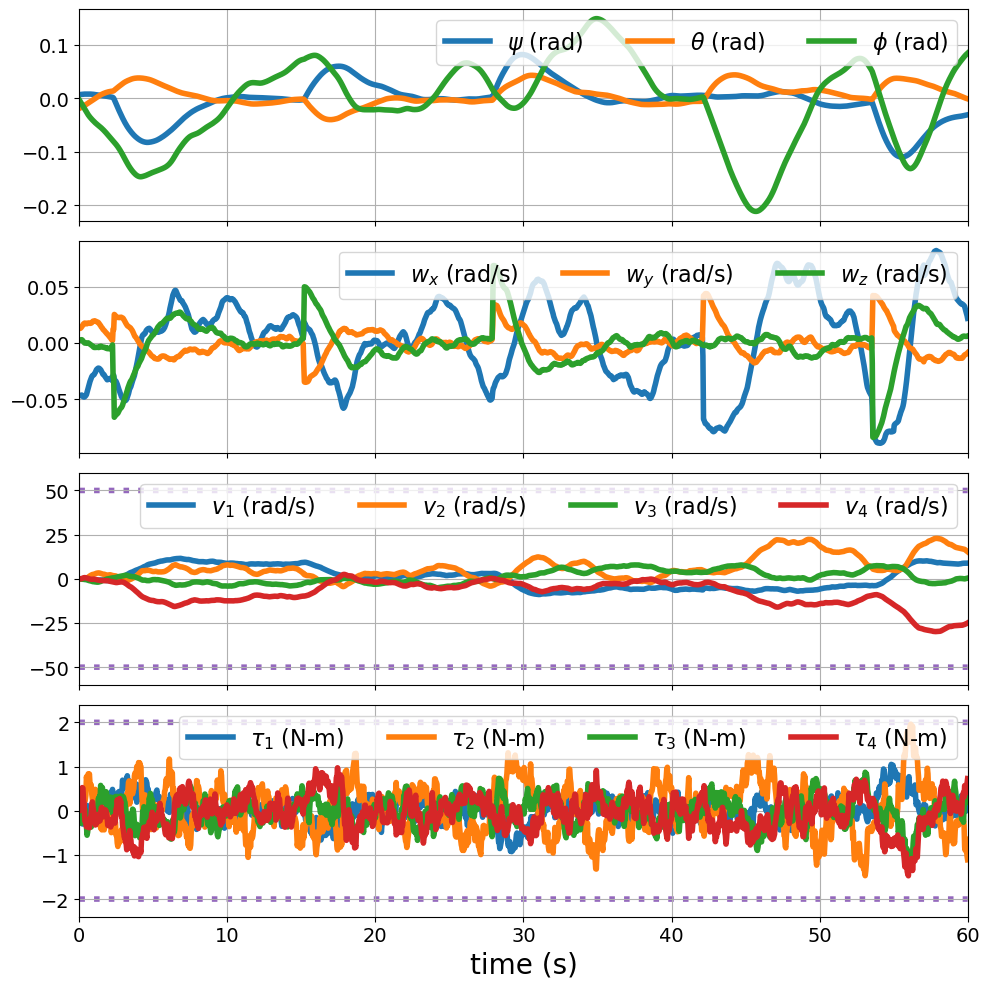

In [12]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Run a single trial with specified initial conditions.

In [17]:
# Reset the simulator with initial conditions
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

# Reset the controller
controller.reset()

# Run the trial
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

# Print if the cat successfully docked or not
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat docked.


Plot both the error in the state and the error in the state estimate with respect to time.

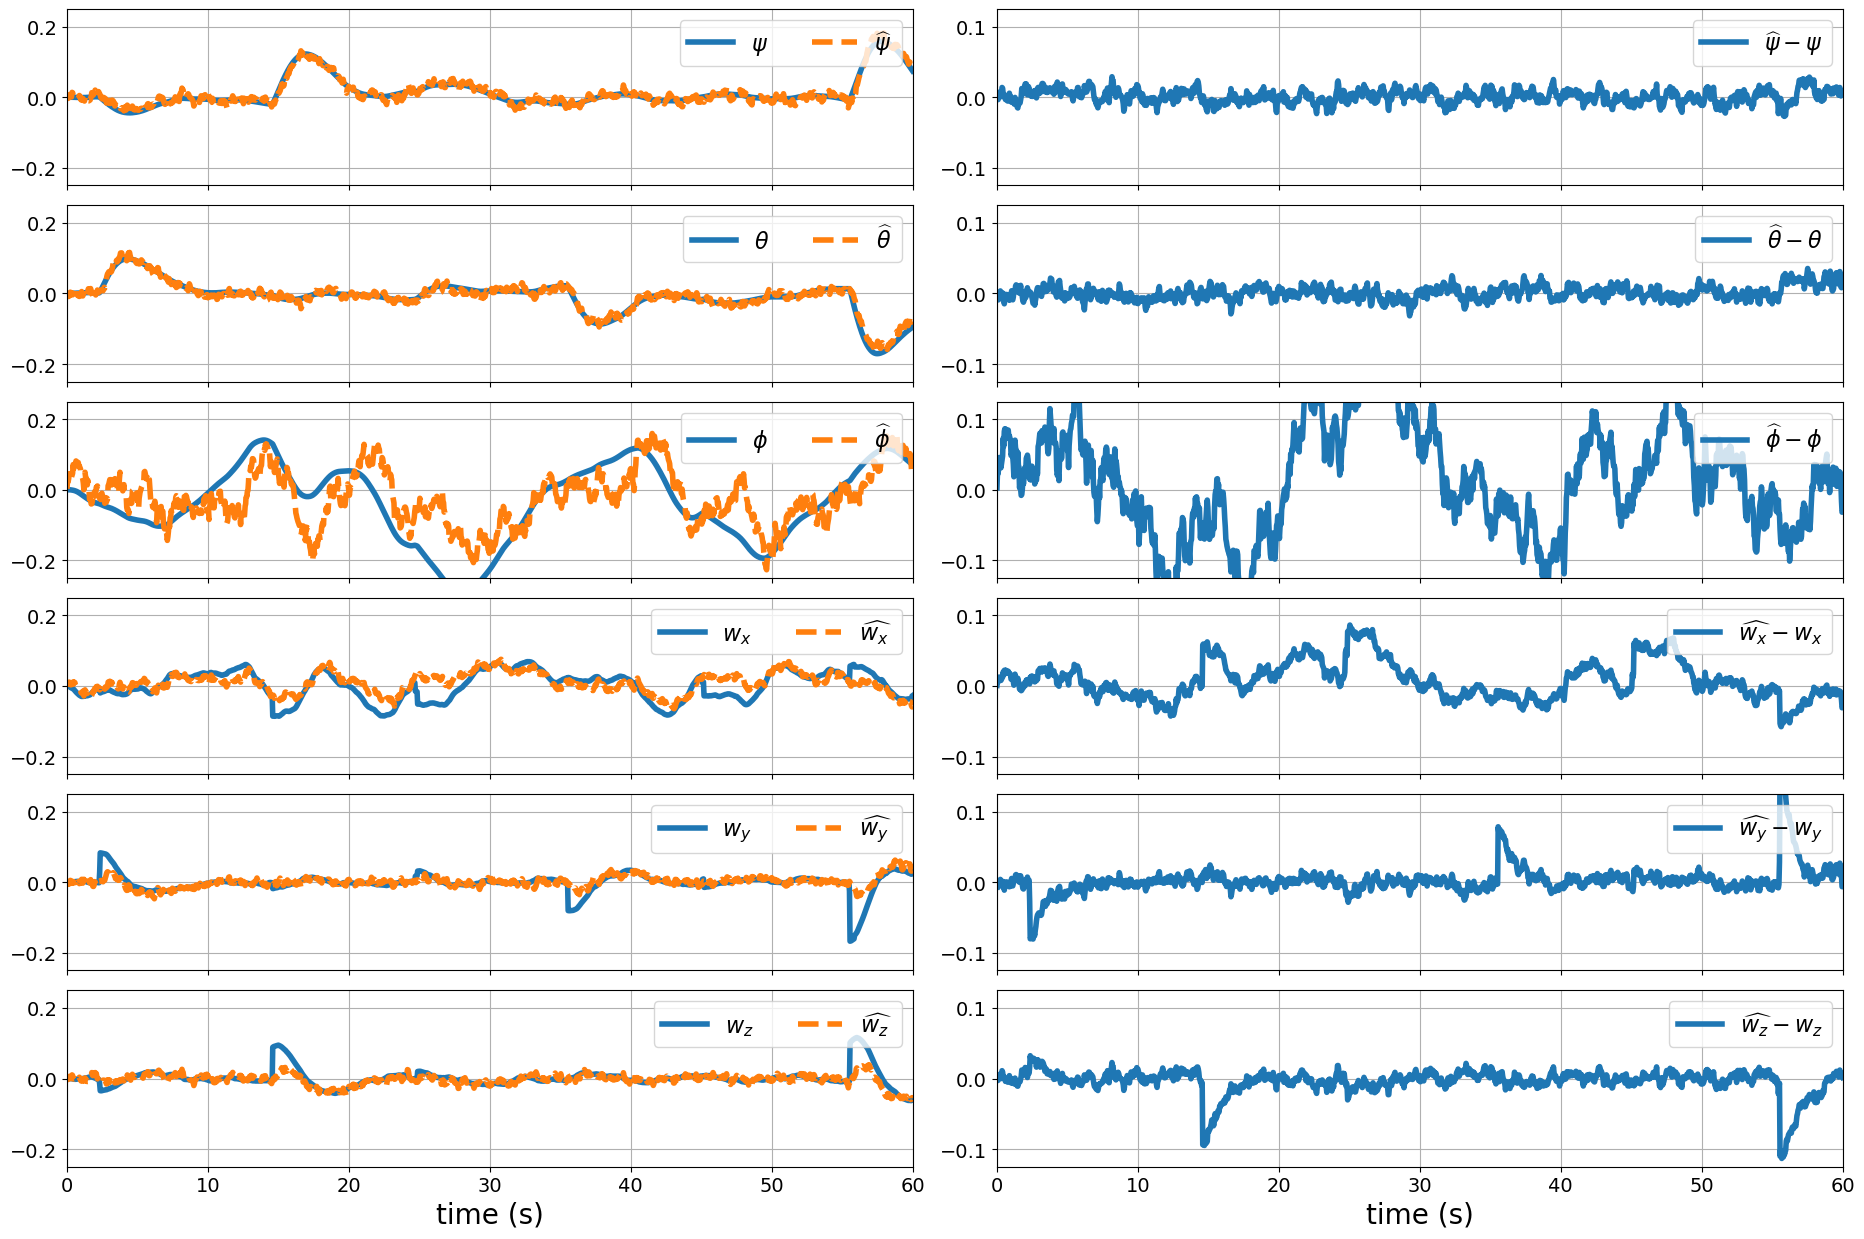

In [18]:
# Pair each set of data with its respective variable name
t = data['t']
psi = data['psi']
theta = data['theta']
phi = data['phi']
w_x = data['w_x']
w_y = data['w_y']
w_z = data['w_z']
xhat = data['xhat']
psihat = xhat[:, 0]
thetahat = xhat[:, 1]
phihat = xhat[:, 2]
w_xhat = xhat[:, 3]
w_yhat = xhat[:, 4]
w_zhat = xhat[:, 5]

# Define the shape and layout of the figure
fig, ((ax_psi, ax_psie), (ax_theta, ax_thetae), (ax_phi, ax_phie), (ax_w_x, ax_w_xe), (ax_w_y, ax_w_ye), (ax_w_z, ax_w_ze)) = plt.subplots(
    6, 2, figsize=(18.75, 12.5), sharex=True,
)

# Plot each variable in its respective subplot
ax_psie.plot(t, psihat - psi, label=r'$\widehat{\psi} - \psi$', linewidth=4)
ax_thetae.plot(t, thetahat - theta, label=r'$\widehat{\theta} - \theta$', linewidth=4)
ax_phie.plot(t, phihat - phi, label=r'$\widehat{\phi} - \phi$', linewidth=4)
ax_w_xe.plot(t, w_xhat - w_x, label=r'$\widehat{w_x} - w_x$', linewidth=4)
ax_w_ye.plot(t, w_yhat - w_y, label=r'$\widehat{w_y} - w_y$', linewidth=4)
ax_w_ze.plot(t, w_zhat - w_z, label=r'$\widehat{w_z} - w_z$', linewidth=4)
ax_psi.plot(t, psi, label=r'$\psi$', linewidth=4)
ax_theta.plot(t, theta, label=r'$\theta$', linewidth=4)
ax_phi.plot(t, phi, label=r'$\phi$', linewidth=4)
ax_w_x.plot(t, w_x, label=r'$w_x$', linewidth=4)
ax_w_y.plot(t, w_y, label=r'$w_y$', linewidth=4)
ax_w_z.plot(t, w_z, label=r'$w_z$', linewidth=4)
ax_psi.plot(t, psihat, '--', label=r'$\widehat{\psi}$', linewidth=4)
ax_theta.plot(t, thetahat, '--', label=r'$\widehat{\theta}$', linewidth=4)
ax_phi.plot(t, phihat, '--', label=r'$\widehat{\phi}$', linewidth=4)
ax_w_x.plot(t, w_xhat, '--', label=r'$\widehat{w_x}$', linewidth=4)
ax_w_y.plot(t, w_yhat, '--', label=r'$\widehat{w_y}$', linewidth=4)
ax_w_z.plot(t, w_zhat, '--', label=r'$\widehat{w_z}$', linewidth=4)

# Set the same style for each subplot in the figure
ax_psi.grid()
ax_psi.legend(fontsize=16, ncol=4, loc='upper right')
ax_psi.tick_params(labelsize=14)
ax_theta.grid()
ax_theta.legend(fontsize=16, ncol=4, loc='upper right')
ax_theta.tick_params(labelsize=14)
ax_phi.grid()
ax_phi.legend(fontsize=16, ncol=4, loc='upper right')
ax_phi.tick_params(labelsize=14)
ax_w_x.grid()
ax_w_x.legend(fontsize=16, ncol=4, loc='upper right')
ax_w_x.tick_params(labelsize=14)
ax_w_y.grid()
ax_w_y.legend(fontsize=16, ncol=4, loc='upper right')
ax_w_y.tick_params(labelsize=14)
ax_w_z.grid()
ax_w_z.legend(fontsize=16, ncol=4, loc='upper right')
ax_w_z.tick_params(labelsize=14)
ax_psie.grid()
ax_psie.legend(fontsize=16, ncol=4, loc='upper right')
ax_psie.tick_params(labelsize=14)
ax_thetae.grid()
ax_thetae.legend(fontsize=16, ncol=4, loc='upper right')
ax_thetae.tick_params(labelsize=14)
ax_phie.grid()
ax_phie.legend(fontsize=16, ncol=4, loc='upper right')
ax_phie.tick_params(labelsize=14)
ax_w_xe.grid()
ax_w_xe.legend(fontsize=16, ncol=4, loc='upper right')
ax_w_xe.tick_params(labelsize=14)
ax_w_ye.grid()
ax_w_ye.legend(fontsize=16, ncol=4, loc='upper right')
ax_w_ye.tick_params(labelsize=14)
ax_w_ze.grid()
ax_w_ze.legend(fontsize=16, ncol=4, loc='upper right')
ax_w_ze.tick_params(labelsize=14)

# Set the y-limits on each subplot
ax_psi.set_ylim(-0.25, 0.25)
ax_theta.set_ylim(-0.25, 0.25)
ax_phi.set_ylim(-0.25, 0.25)
ax_w_x.set_ylim(-0.25, 0.25)
ax_w_y.set_ylim(-0.25, 0.25)
ax_w_z.set_ylim(-0.25, 0.25)
ax_psie.set_ylim(-0.125, 0.125)
ax_thetae.set_ylim(-0.125, 0.125)
ax_phie.set_ylim(-0.125, 0.125)
ax_w_xe.set_ylim(-0.125, 0.125)
ax_w_ye.set_ylim(-0.125, 0.125)
ax_w_ze.set_ylim(-0.125, 0.125)

# Label the x-axis for each set of subplots and set the x-limits
ax_w_z.set_xlabel('time (s)', fontsize=20)
ax_w_z.set_xlim([data['t'][0], data['t'][-1]])
ax_w_ze.set_xlabel('time (s)', fontsize=20)
ax_w_ze.set_xlim([data['t'][0], data['t'][-1]])

# Show the figure
fig.tight_layout()
plt.show()

Run several trials and collect the data from all trials into one big data set.  Identify the overall docking success rate.

In [19]:
# Set the number of trials
numTrials = 1000

# Create a list of the data from each trial
dataSet = [None]*numTrials

# Run the trials and collect the data
for i in range(numTrials):
    # Reset the simulator with random initial conditions
    simulator.reset(
        initial_conditions=None,
        scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
        space_debris=True,      # <-- whether or not there is space debris
        docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
    )

    # Reset the controller
    controller.reset()

    # Run the trial
    dataSet[i] = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=62.5,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
        print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )

Plot a histogram of the root-mean-square error in both the state and the state estimate for all trials.

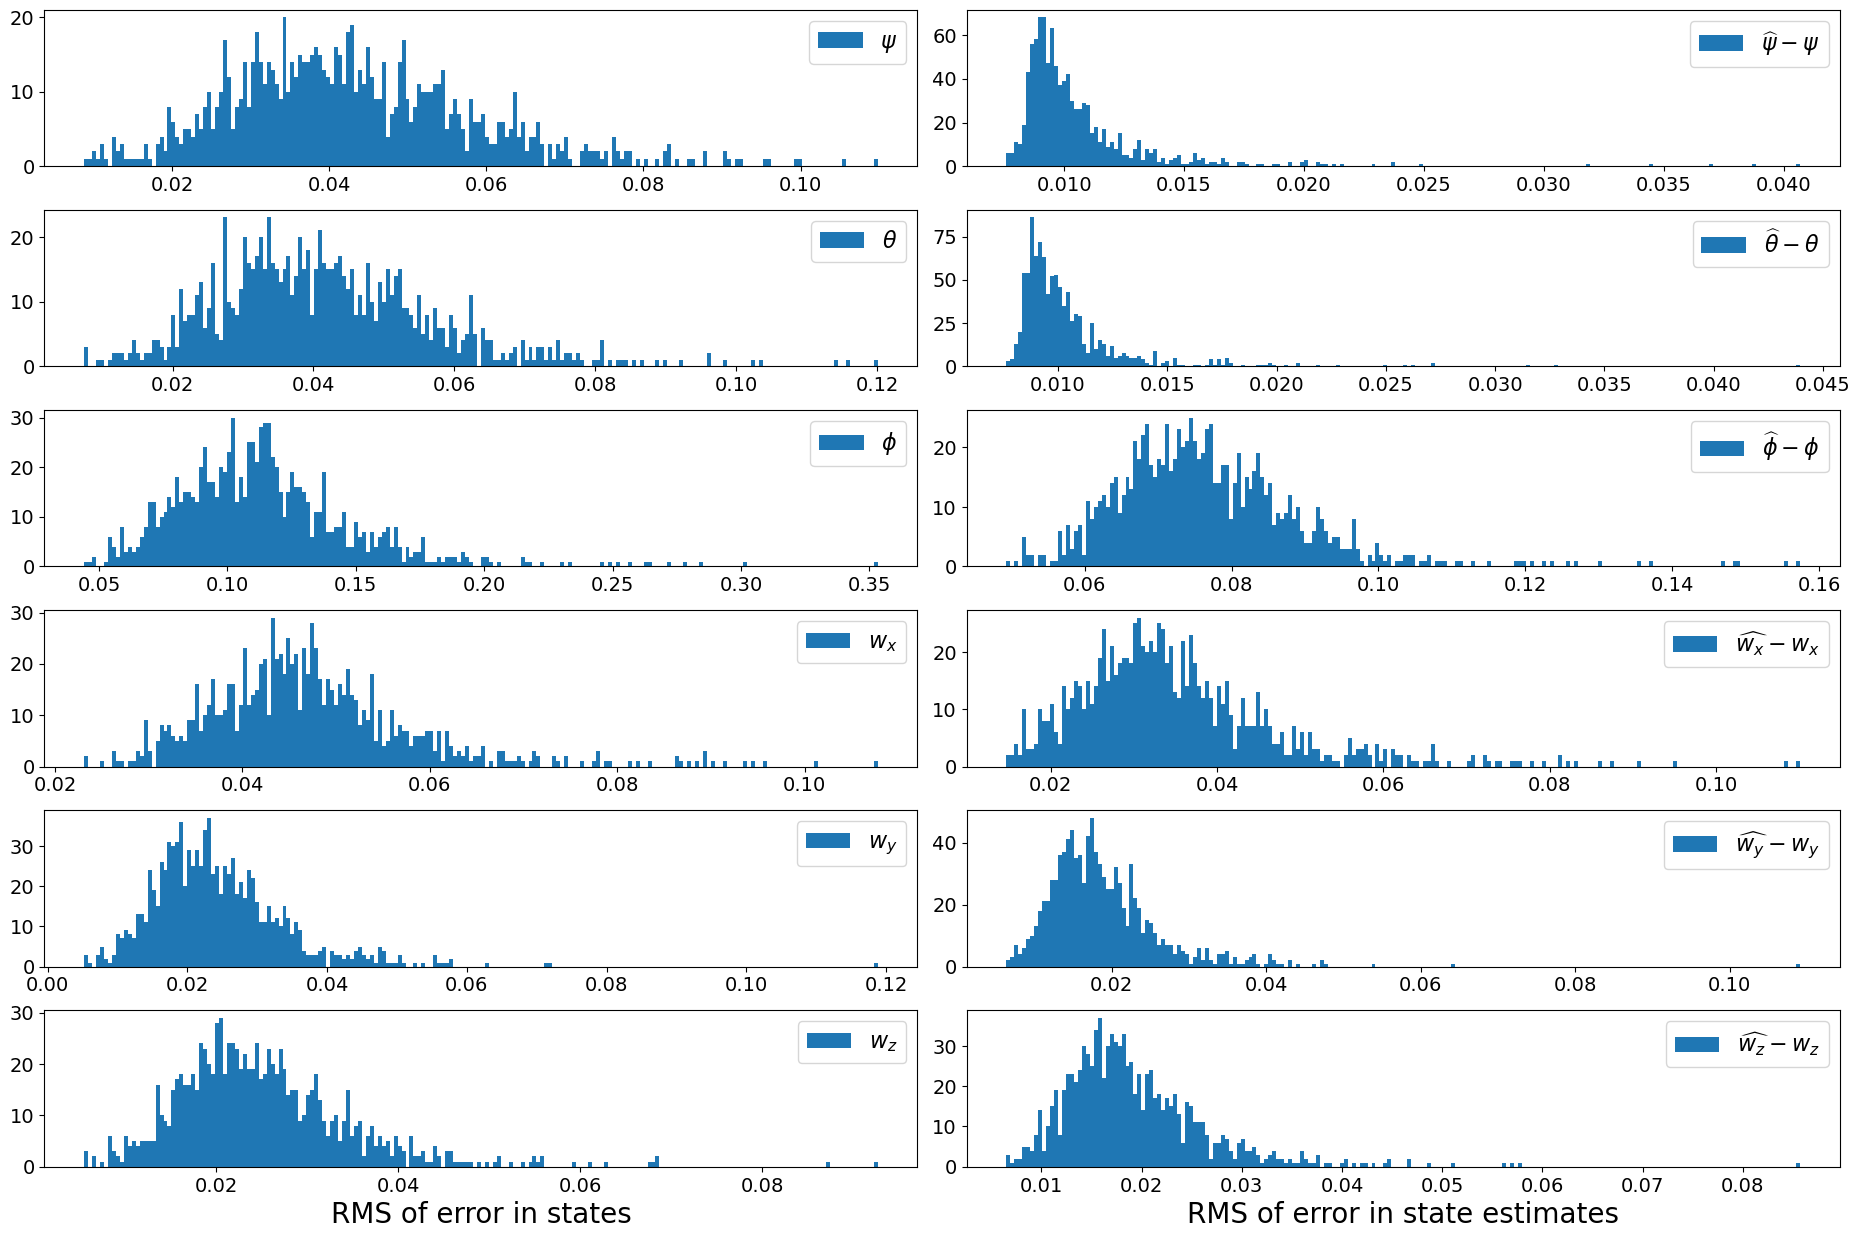

In [20]:
# Find RMS of errors
def RootMeanSquarror(points, hats):
    hat_errors = hats - points
    points_rms = np.sqrt(np.sum(points**2)/len(points))
    hats_rms = np.sqrt(np.sum(hat_errors**2)/len(hat_errors))
    return points_rms, hats_rms

# Initialize empty lists for RMS values for each trial
psi_rms = np.empty(numTrials)
psihat_rms = np.empty(numTrials)
theta_rms = np.empty(numTrials)
thetahat_rms = np.empty(numTrials)
phi_rms = np.empty(numTrials)
phihat_rms = np.empty(numTrials)
w_x_rms = np.empty(numTrials)
w_xhat_rms = np.empty(numTrials)
w_y_rms = np.empty(numTrials)
w_yhat_rms = np.empty(numTrials)
w_z_rms = np.empty(numTrials)
w_zhat_rms = np.empty(numTrials)

# Find RMS values for each state or state estimate
for i in range(numTrials):
    data = dataSet[i]
    xhat = data['xhat']
    psi_rms[i], psihat_rms[i] = RootMeanSquarror(data['psi'], xhat[:, 0])
    theta_rms[i], thetahat_rms[i] = RootMeanSquarror(data['theta'], xhat[:, 1])
    phi_rms[i], phihat_rms[i] = RootMeanSquarror(data['phi'], xhat[:, 2])
    w_x_rms[i], w_xhat_rms[i] = RootMeanSquarror(data['w_x'], xhat[:, 3])
    w_y_rms[i], w_yhat_rms[i] = RootMeanSquarror(data['w_y'], xhat[:, 4])
    w_z_rms[i], w_zhat_rms[i] = RootMeanSquarror(data['w_z'], xhat[:, 5])

# Place RMS lists in array, with labels corresponding to their subplots in the figure
v_rms = np.array([psi_rms, theta_rms, phi_rms, w_x_rms, w_y_rms, w_z_rms])
h_rms = np.array([psihat_rms, thetahat_rms, phihat_rms, w_xhat_rms, w_yhat_rms, w_zhat_rms])
labels = np.array([[r'$\psi$', r'$\theta$', r'$\phi$', r'$w_x$', r'$w_y$', r'$w_z$'], [r'$\widehat{\psi} - \psi$', r'$\widehat{\theta} - \theta$', r'$\widehat{\phi} - \phi$', r'$\widehat{w_x} - w_x$', r'$\widehat{w_y} - w_y$', r'$\widehat{w_z} - w_z$']])

# Create the figure
fig, axs = plt.subplots(6, 2, figsize=(18.75, 12.5))

# Make a histogram in each subplot with the corresponding data
for i in range(6):
    axs[i][0].hist(v_rms[i], bins=int(numTrials/5), label=labels[0][i])
    axs[i][1].hist(h_rms[i], bins=int(numTrials/5), label=labels[1][i])
    axs[i][0].legend(fontsize=16, ncol=4, loc='upper right')
    axs[i][1].legend(fontsize=16, ncol=4, loc='upper right')
    axs[i][0].tick_params(labelsize=14)
    axs[i][1].tick_params(labelsize=14)
axs[5][0].set_xlabel('RMS of error in states', fontsize=20)
axs[5][1].set_xlabel('RMS of error in state estimates', fontsize=20)

# Show the figure
fig.tight_layout()
plt.show()